# Dimension Manipulation on MNIST with Autoencoders

Autoencoders are an unsupervised learning technique which uses neural networks for the task of representation learning. It encodes, or compress, the inputs in a lower dimensional feature space (latent space), and then decode, or reconstruct, them back into original form starting from their latent space representations
The general function of an autoencoder, is mapping an input x to an output - reconstruction r through an internal representation h. 
By penalizing the network according to the reconstruction error, the model can learn the most important attributes of the input data and how to best reconstruct the original input from an "encoded" state. This encoding will learn and describe latent attributes of the input data, which is a nonlinear generalization of PCA: whereas PCA attempts to discover a lower dimensional hyperplane which describes the original data, autoencoders are capable of learning nonlinear manifolds.

The autoencoder has two components: 
<br /><br />
* **Encoder:** It has a mapping from x to h, f(x)=h
<br />
* **Decoder:** It has a mapping from h to r, g(h)=r

We pass input data through an encoder that makes a compressed representation of the input.
The encoder network is outputting a single value for each encoding dimension.
Each dimension of the encoding vector represents some learned attribute about the data. The decoder network then subsequently takes these values and attempts to recreate the original input.

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import optim
from torchvision import datasets


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device", device)

Training on device cuda


In [2]:
# turn PIL image into a 3D Torch float tensor with values between [0, 1]
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

data_path = 'MNIST/processed/training.pt'

train_data = MNIST(root = data_path, train=True, download=True, transform=transform)
test_data = MNIST(root = data_path, train=False, download=True, transform=transform)

--2021-08-04 04:52:29--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-08-04 04:52:29--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.7’

MNIST.tar.gz.7          [             <=>    ]  33.20M  11.4MB/s    in 2.9s    

2021-08-04 04:52:33 (11.4 MB/s) - ‘MNIST.tar.gz.7’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [3]:
# load training and test datasets, dataset as a subclass of torch.utils.data.Dataset
data_path = 'MNIST/processed/training.pt'

train_data = datasets.MNIST(root = data_path, download=True, train=True, transform=transform )
test_data   = datasets.MNIST(root = data_path, download=True, train=False, transform=transform )

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# number of samples per batch to load
batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=True)

test_loader   = torch.utils.data.DataLoader(dataset = test_data, 
                                            batch_size=batch_size, 
                                            num_workers=num_workers, 
                                            shuffle=True)


### Visualize the data to check if data has loaded correctly


In [38]:
# get a single batch of images for testing:
test_batch = next(iter(test_loader))[0].to(device)

# obtain one images to display
images = test_batch[0].cpu()

# get one image from the batch, squeezing out the batch dim
img = np.squeeze(images[0])
print("image dimension:", img.shape)

# check if images are alredy normalized
print("min pixel value: ", img.min())
print("max pixel value: ", img.max())

image dimension: torch.Size([28, 28])
min pixel value:  tensor(0.)
max pixel value:  tensor(1.)


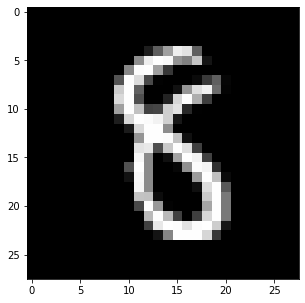

In [39]:
#display an image
fig = plt.figure(figsize = (5,5)) 
# add_subplot(nrows, ncols, index), the subplot will take the 
# index position on a grid with nrows rows and ncols columns
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Linear Autoencoders

Linear autoencoders consist of one linear layer encoder and decoder connected by a compressed representation unit.

Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

The model architecture is trying to achive targets that are the same as the inputs:

The encoder has one linear layer with input dim of 28x28=784 and output = encoding_dim, and the decoder has one linear layer with inputdim of encoding_dim, and output back to the original image size of 28x28.

In [56]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        # a subclass of nn.Module inhereting all methods of the superclass 
        # nn.Module including __call__ method which calls the forward function
        # from the subclass
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        self.fc2 = nn.Linear(intermediate_dim, latent_dim)
        
        ## decoder ##
        self.fc3 = nn.Linear(latent_dim, intermediate_dim)
        self.fc4 = nn.Linear(intermediate_dim, original_dim)
        
    # an imput image is compressed to its latent space representation
    def encode(self, input):
        # add layer, with relu activation function
        x = self.fc1(input)
        x = F.relu(x)
        latent_rep = self.fc2(x)
        
        return latent_rep
    
    # a latent vector is turned into an image
    def decode(self, latent_rep):
        x = self.fc3(latent_rep)
        x = F.relu(x)
        x = self.fc4(x)
        # for output layer use sigmoid for scaling from 0 to 1
        reconstruction = torch.sigmoid(x)
        
        return reconstruction.view(-1, 1, np.sqrt(original_dim).astype(int), np.sqrt(original_dim).astype(int))
    
    def forward(self, input):
        # flatten the input image
        laten_rep = self.encode(input.view(-1, original_dim))
        # decode the latent vector
        reconstruction = self.decode(laten_rep)
        
        return reconstruction
        

In [57]:
original_dim = 28*28
intermediate_dim = 400
latent_dim = 20
num_epochs = 3

In [58]:
# NB: move the model to GPU before constructing optimizers for it
model = Autoencoder().to(device)

# print number of model parameters
numel_list = [p.numel() for p in model.parameters()]
print("total number of model parameters:", sum(numel_list))
print("model parameters per layer:", numel_list)

# define loss function as an element-wise mean square error
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

total number of model parameters: 644804
model parameters per layer: [313600, 400, 8000, 20, 8000, 400, 313600, 784]


In [55]:
# flatten the images, pass them into the autoencoder, and record the training loss 
def training_loop():
    """ Train the model running through the entire dataset multiple times with a for loop"""
    
    # Display the test batch to compare with the reconstructed from test batch images:
    image_grid = torchvision.utils.make_grid(test_batch.cpu(), nrow=batch_size)
    
    plt.figure(figsize=(12,12))
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.title("Test batch input images")
    plt.axis("off")
    plt.pause(0.05)
    
    # Set model to training mode
    model.train() 
    
    train_loss =[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        running_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            
            data, _ = batch
            data = data.to(device)
            
            #print("size of batch of input images:", data.size())
            # zero the parameter gradients to clear the adjustments of the weights
            optimizer.zero_grad()
            
            #forward pass to get batch of reconstructed images
            reconstruct_imgs = model(data) 
            #print("size of batch of reconstructed images: ", reconstruct_imgs.size())
            loss = loss_fn(reconstruct_imgs.squeeze(), data.squeeze())
            
            # compute the gradient of the loss w.r.t. model parameters 
            loss.backward()
            
            # updating parameters when adjusting the weights
            optimizer.step()
            
            # add the loss to the training set's running loss
            running_loss += loss.item()*images.size(0)
            
            if batch_idx % 1000 == 0:
                with torch.no_grad():
                    # Output the images reconstructed from the test batch:
                    reconstruct_imgs = model(test_batch).detach().cpu()
                    image_grid = torchvision.utils.make_grid(reconstruct_imgs, nrow=batch_size)
                    plt.figure(figsize=(20,10))
                    plt.imshow(image_grid.permute(1, 2, 0))
                    plt.title("Test batch reconstructed images for itteration: " + str(batch_idx)) 
                    plt.axis("off")
                    plt.pause(0.05)
               
        
        # average trainig stats differs than running_loss/len(train_loader.dataset)
        epoch_loss = running_loss/len(train_loader)
        
        train_loss.append(epoch_loss)
        
        print("Trianing Loss: {:.4f}".format(epoch_loss))
        print()
            
    plt.plot(train_loss, label='Training Loss')
    plt.legend(frameon=False)
    plt.title('Model Training Loss')
    plt.show()
    

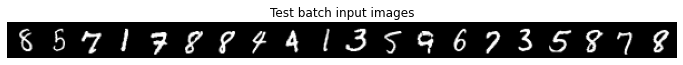

Epoch 0/2
----------


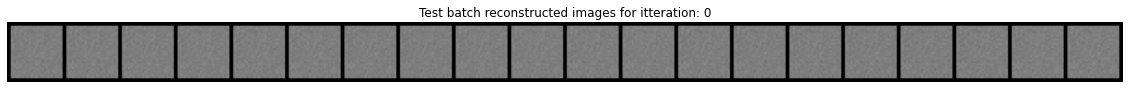

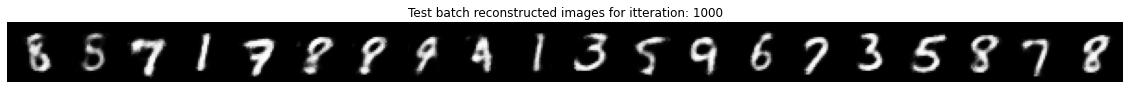

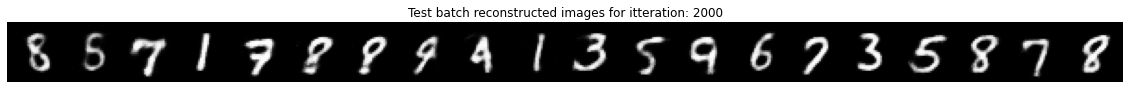

Trianing Loss: 0.0183

Epoch 1/2
----------


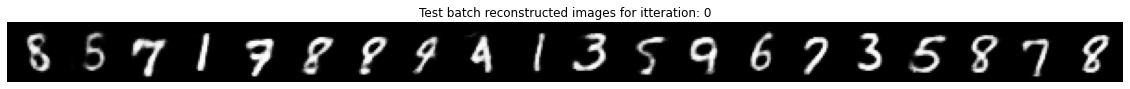

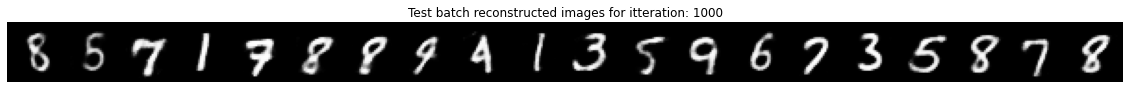

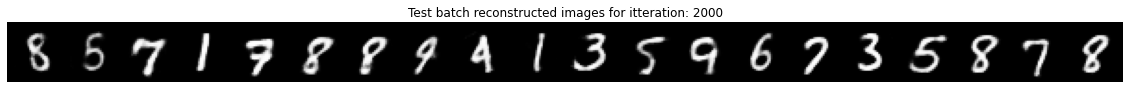

Trianing Loss: 0.0104

Epoch 2/2
----------


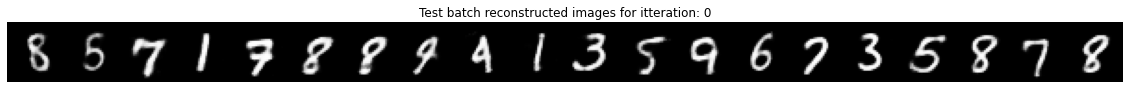

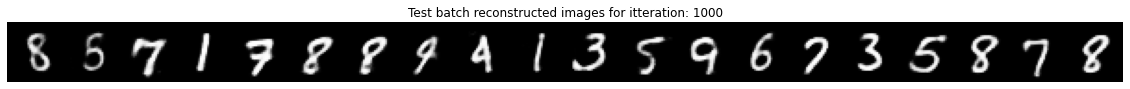

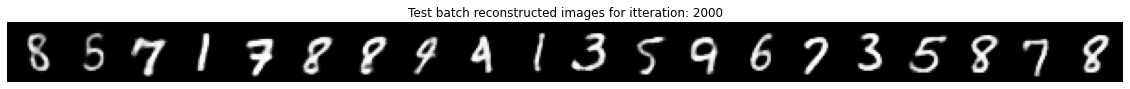

Trianing Loss: 0.0093



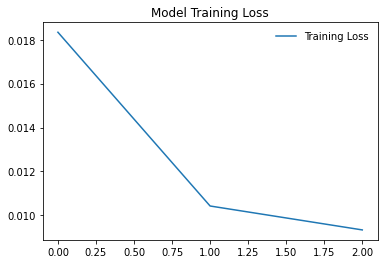

In [59]:
training_loop()

## Convolutional Autoencoders

In [69]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        ## Encoder ##
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1)
        
        ## Decoder ##
        self.t_conv1 = nn.ConvTranspose2d(4, 8, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2)
        
    def encode(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        latent_rep = F.relu(x)
        return latent_rep
    
    def decode(self, latent_rep):
        x = self.t_conv1(latent_rep)
        x = F.relu(x)
        x = self.t_conv2(x)
        x = F.relu(x)
        # for output layer use sigmoid for scaling from 0 to 1
        reconstruction = torch.sigmoid(x)
        
        return reconstruction.view(-1, 1, np.sqrt(original_dim).astype(int), np.sqrt(original_dim).astype(int))       
    
    def forward(self, input):
        latent_rep = self.encode(input)
        reconstruction = self.decode(latent_rep)
        return reconstruction 
    

In [70]:
model = ConvAutoencoder().to(device)

print(model)

# print number of model parameters
numel_list = [p.numel() for p in model.parameters()]

print("total number of model parameters:", sum(numel_list))
print("model parameters per layer:", numel_list)

# define loss function as the measure of the MSE between the output and the input also known as the
# reconstruction loss, which penalizes the network for creating outputs different from the input
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

ConvAutoencoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (t_conv1): ConvTranspose2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
)
total number of model parameters: 541
model parameters per layer: [72, 8, 288, 4, 128, 8, 32, 1]


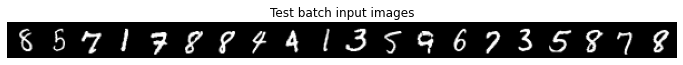

Epoch 0/2
----------


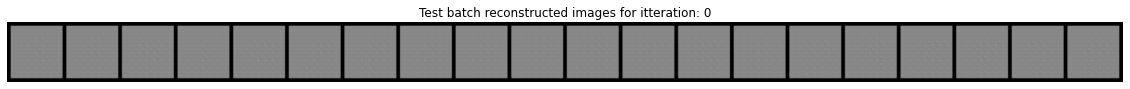

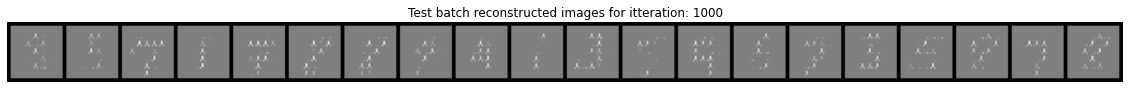

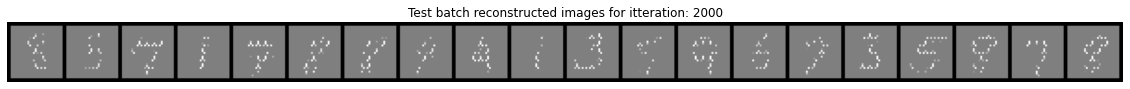

Trianing Loss: 0.2280

Epoch 1/2
----------


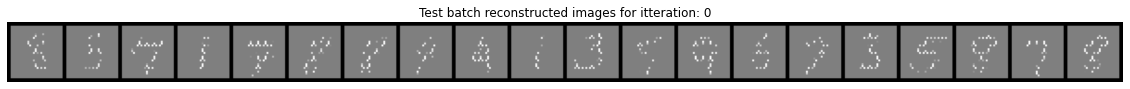

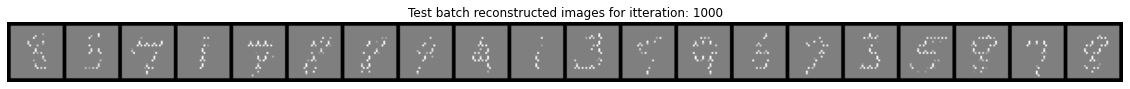

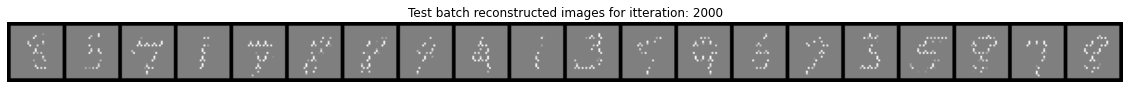

Trianing Loss: 0.2256

Epoch 2/2
----------


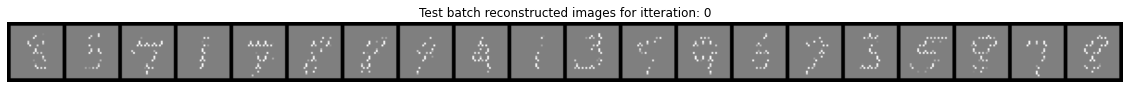

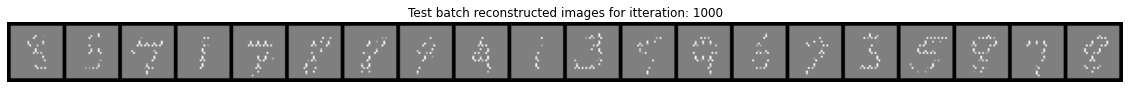

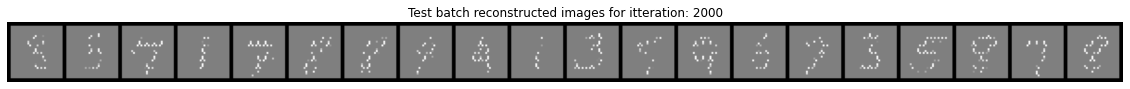

Trianing Loss: 0.2256



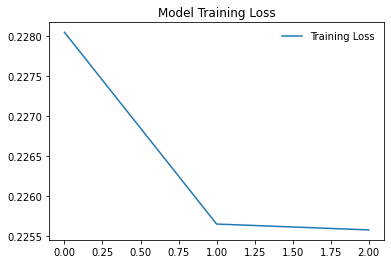

In [71]:
training_loop()

## Variational Autoencoder

VAE does not reconstruct an image from its latent space representation, but it generates a new image from a latent space distribution learned through training. A VAE provides a probabilistic manner for describing an observation in latent space. Rather than having a single value to describe each latent state attribute, encoder represent each latent attribute for a given input as a probability distribution. Assuming a Gaussian distribution of the latent space vectors, the encoder generate two dimensional vectors representing the *mean* and *standard deviation*. By constructing the encoder model to output a statistical distribution, i.e. range of possible values which are randomly sampled to feed into the decoder model, we enforcing a continuous, smooth latent space representation. For any sampling of the latent distributions, we're expecting our decoder model to be able to accurately reconstruct the input.

The main benefit of a variational autoencoder is its capability of learning smooth latent state representations of the input data.

The **loss function** has two components: **MSE** of the autoencoder and the **KL divergence**, which measures the difference between two distributions.

In [17]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder1 = nn.Linear(784, 400)
        self.encoder2mu = nn.Linear(400, 20)
        self.encoder2logvar = nn.Linear(400, 20)

        self.decoder1 = nn.Linear(20, 400)
        self.decoder2 = nn.Linear(400, 784)

    def encode(self, input):
        x = self.encoder1(input)
        x = F.relu(x)
        mu = self.encoder2mu(x)
        logvar = self.encoder2logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        
        """ VAE performs random sampling on the latent space, an operation which can not be
            perform back propagation on. We introduce epsilon when an latent vector z is drown, 
            such that z = mu + epsilon*sigma, where mu and sigma are learned by the algorithm 
            and the normal distribution for epsilon we are going to randomly sample. 
        
        The input parameters are the:
        
        [batch_size, latent_dim] mean matrix mu and
        [batch_size, latent_dim] variance matrix logvar
        
        """ 
        
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        
        return mu + eps*std

    # Take in a latent vector and produce an image:
    def decode(self, z):
        x = self.decoder1(z)
        x = F.relu(x)
        x = self.decoder2(x)
        reconstruction = torch.sigmoid(x)
        return reconstruction.view(-1, 1, 28, 28)

    def forward(self, input):
        mu, logvar = self.encode(input.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [18]:
model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [19]:
def loss_fn(recon_x, x, mu, logvar):
    
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # Kullback-Leibler divergence measures how much the learned distribution deviates 
    # from the unit Gaussian:
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD

In [20]:
original_dim = 28*28
intermediate_dim = 400
latent_dim = 20
num_epochs = 10

#seed = 321
torch.manual_seed(seed)

# Random noise vector used to generate test images by sampling
eps = torch.randn((16,20)).to(device)

In [23]:
def train_vae():
    # Set model to training mode
    model.train() 
    
    train_loss =[]


    for epoch in range(num_epochs):
    
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        running_loss = 0.0
    
        for batch_idx, batch in enumerate(train_loader):
            
            data, _ = batch
            data = data.to(device)
        
            optimizer.zero_grad()
        
            recon_batch, mu, logvar = model(data)
            
            loss = loss_fn(recon_batch, data, mu, logvar)   
            
            loss.backward()
            optimizer.step()
            # add the loss to the training set's running loss
            running_loss += loss.item()
        
            if batch_idx % 1000 == 0:
                # Display the images generated by the VAE from random latent vector epsilon
                with torch.no_grad():
                    generated = model.decode(eps)
                    image_grid = torchvision.utils.make_grid(generated.detach().cpu(), nrow=16)
        
                    plt.figure(figsize=(20,10))
                    plt.imshow(image_grid.permute(1, 2, 0))
                    plt.title("generated images for batch number: " + str(batch_idx)) 
                    plt.axis("off")
                    plt.pause(0.05)
                    
        # average training loss
        epoch_loss = running_loss/len(train_loader.dataset)
        
        train_loss.append(epoch_loss)
        
        print("Trianing Loss: {:.4f}".format(epoch_loss))
        print()  
        
    plt.plot(train_loss, label='Training Loss')
    plt.legend(frameon=False)
    plt.title('Model Training Loss')
    plt.show()

Epoch 0/2
----------


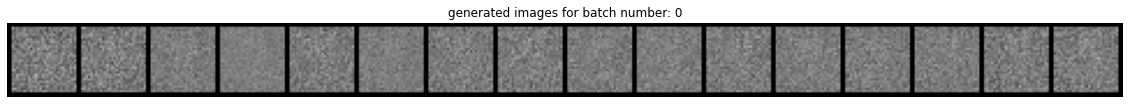

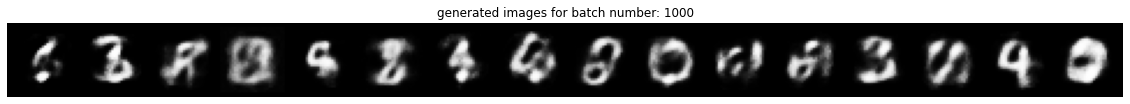

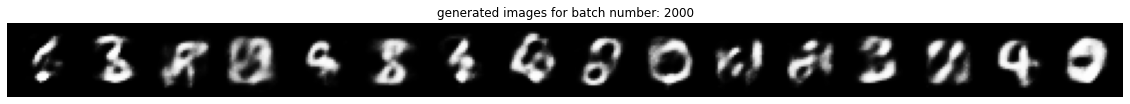

Trianing Loss: 25.0903

Epoch 1/2
----------


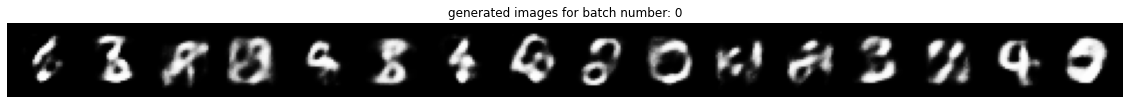

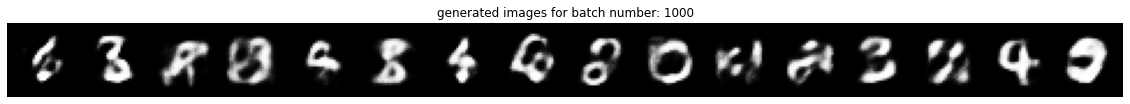

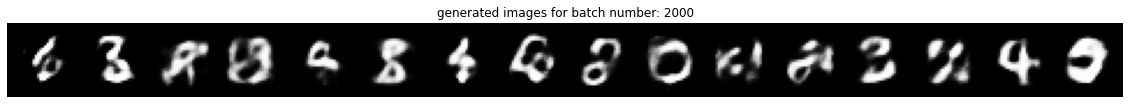

Trianing Loss: 19.5735

Epoch 2/2
----------


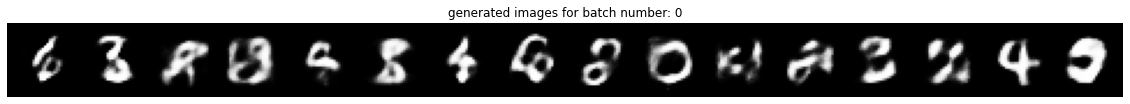

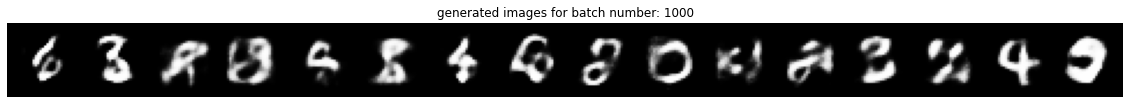

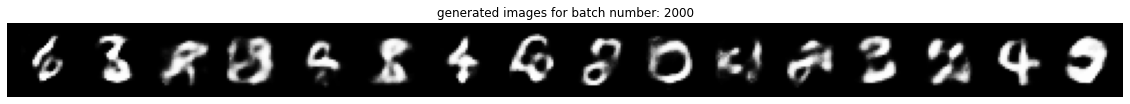

Trianing Loss: 18.6427



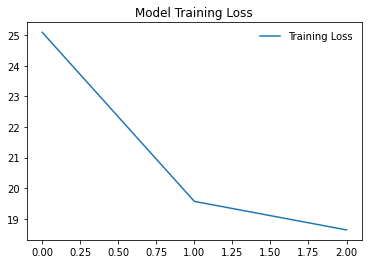

In [24]:
train_vae()

In [25]:
def test_vae():

    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for batch_idx, batch in enumerate(test_loader):
            
            data, _ = batch
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            
            loss = loss_fn(recon_batch, data, mu, logvar)
            
            test_loss += loss.item()
            
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))
                     

In [26]:
test_vae()

Test set loss: 18.1088


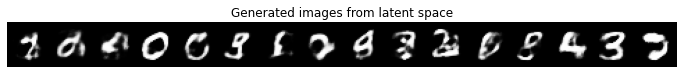

In [32]:
# generate num_samples images from latent sapce
num_samples = 16

with torch.no_grad():
    # Returns a 16x20 tensor filled with random numbers from a normal distribution with mean 0 and variance 1
    samples = torch.randn(num_samples, latent_dim).to(device)    
    recon_samples = model.decode(samples).cpu()
    image_grid = torchvision.utils.make_grid(recon_samples.detach().cpu(), nrow=num_samples)
    
    
    plt.figure(figsize=(12, 4))
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.title("Generated images from latent space") 
    plt.axis("off")
    plt.pause(0.05)
    

VAE generates images resembling handwritten digits "out of nothing"!